In [24]:
# Importing required libraries
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.io

In [25]:
# Loading the dataset
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [26]:
x_train_clean, x_train_dist = utils.cifar10_awgn(x_train)

5000/50000 images done!
10000/50000 images done!
15000/50000 images done!
20000/50000 images done!
25000/50000 images done!
30000/50000 images done!
35000/50000 images done!
40000/50000 images done!
45000/50000 images done!
50000/50000 images done!
Adding AWGN done!


In [27]:
x_test_clean, x_test_dist = utils.cifar10_awgn(x_test)

5000/10000 images done!
10000/10000 images done!
Adding AWGN done!


In [28]:
x_train_clean.shape, x_train_dist.shape, x_test_clean.shape, x_test_dist.shape

((250000, 3072), (250000, 3072), (50000, 3072), (50000, 3072))

In [29]:
# Parameters
learning_rate = 0.1
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 15

# Network Parameters
n_hidden = 2000
# hidden layer size
n_input = 32*32*3 # CIFAR10 data input (img shape: 32*32*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
tilda_X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h': tf.Variable(tf.random_uniform
                             ([n_input, n_hidden],
                              minval = -4*tf.sqrt(6. / (n_input + n_hidden)),
                              maxval = 4*tf.sqrt(6. / (n_input + n_hidden)))),
    'decoder_h': tf.Variable(tf.random_uniform
                             ([n_hidden, n_input],
                              minval = -4*tf.sqrt(6. / (n_input + n_hidden)),
                              maxval = 4*tf.sqrt(6. / (n_input + n_hidden)))),
}
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])),
    'decoder_b': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation
    hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                 biases['encoder_b']))
    return hidden


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation
    output = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h']),
                                 biases['decoder_b']))
    return output

# Construct model
encoder_op = encoder(tilda_X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [30]:
# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(x_train_clean.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_tilda_x = utils.cifar10_next_batch(batch_size, 
                                                              x_train_clean,
                                                              x_train_dist)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_x,
                                                         tilda_X: batch_tilda_x})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
            
    # Visualizing the weights
    W_enc = weights['encoder_h'].eval()
    b_enc = biases['encoder_b'].eval()
    W_dec = weights['decoder_h'].eval()
    b_dec = biases['decoder_b'].eval()
    scipy.io.savemat('cifar10_saves/params_awgn.mat', {'W_enc': W_enc, 'b_enc': b_enc,
                                                       'W_dec': W_dec, 'b_dec': b_dec})

    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: x_test_clean[:examples_to_show],
                           tilda_X: x_test_dist[:examples_to_show]})

Epoch: 0001 cost= 18112.681640625
Epoch: 0002 cost= 18378.673828125
Epoch: 0003 cost= 17473.091796875
Epoch: 0004 cost= 17902.630859375
Epoch: 0005 cost= 18299.357421875
Epoch: 0006 cost= 18713.476562500
Epoch: 0007 cost= 17353.572265625
Epoch: 0008 cost= 18585.437500000
Epoch: 0009 cost= 17745.339843750
Epoch: 0010 cost= 17594.685546875
Epoch: 0011 cost= 17673.841796875
Epoch: 0012 cost= 19056.083984375
Epoch: 0013 cost= 17926.457031250
Epoch: 0014 cost= 19010.255859375
Epoch: 0015 cost= 19960.632812500
Epoch: 0016 cost= 18419.794921875
Epoch: 0017 cost= 18772.025390625
Epoch: 0018 cost= 18046.478515625
Epoch: 0019 cost= 17782.248046875
Epoch: 0020 cost= 18770.611328125
Optimization Finished!


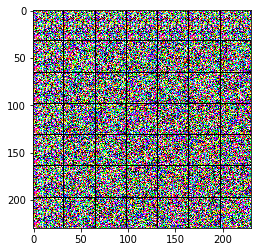

In [31]:
params = scipy.io.loadmat('cifar10_saves/params_awgn.mat')
W = params['W_enc']
vis_w = visualize(W.T, [32, 32], [1, 1], [7, 7], 1)
plt.imshow(vis_w, cmap='gray')
plt.draw()
#plt.savefig('saves/awgn_weights_vis.png')
plt.show()

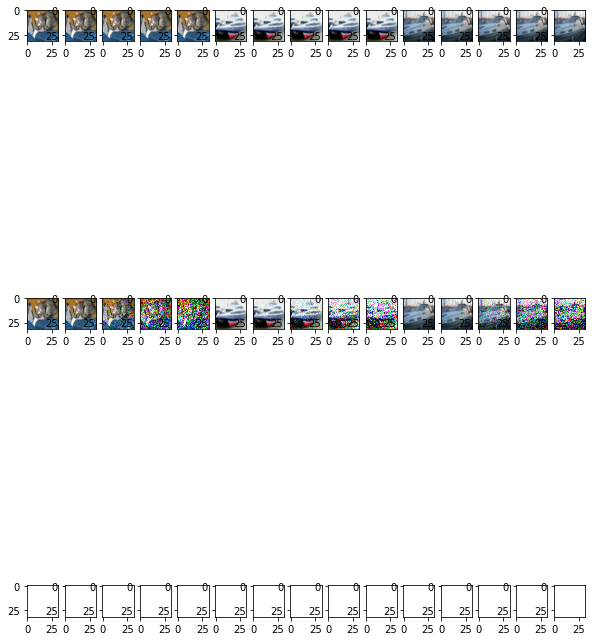

In [32]:
# Compare original images with their reconstructions
f, a = plt.subplots(3, examples_to_show, figsize=(10, examples_to_show))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_test_clean[i], (32, 32, 3)))
    a[1][i].imshow(np.reshape(x_test_dist[i], (32, 32, 3)))
    a[2][i].imshow(np.reshape(encode_decode[i], (32, 32, 3)))
plt.draw()
#plt.savefig('saves/awgn_test_vis.png')
plt.show()

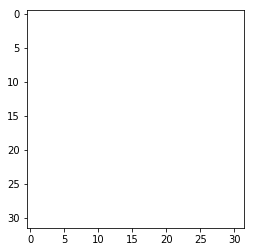

In [33]:
plt.imshow(np.reshape(encode_decode[1, :], (32, 32, 3)))
plt.draw()
plt.show()